<a href="https://colab.research.google.com/github/NickygenN1/tensorflow22/blob/main/transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Leaning with Fine Tuning

In [1]:
import tensorflow as tf

In [2]:
train_path = 'drive/MyDrive/data-food/10_food_classes_all_data/train'
test_path = 'drive/MyDrive/data-food/10_food_classes_all_data/test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                 image_size=IMAGE_SIZE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                image_size=IMAGE_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [3]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [4]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Builing a model with Functional API
more flexibility than Sequential
> Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs`

In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# some model need to rescale
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
x = base_model(inputs)
print(f'shape after passing input to model : {x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
print(f'shape after GlobalAverage2D to model : {x.shape}')

outputs = tf.keras.layers.Dense(10, activation='softmax', name='ouput_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
hist_1 = model_1.fit(train_data, epochs=3, 
                     steps_per_epoch= int(len(train_data) * .1), 
                     validation_data = test_data,
                     validation_steps = int(len(test_data) * .1))

shape after passing input to model : (None, 7, 7, 1280)
shape after GlobalAverage2D to model : (None, 1280)
Epoch 1/3
23/23 [==============================] - 152s 5s/step - loss: 1.9125 - accuracy: 0.4144 - val_loss: 1.3700 - val_accuracy: 0.7277
Epoch 2/3
23/23 [==============================] - 87s 4s/step - loss: 1.2852 - accuracy: 0.6766 - val_loss: 0.8775 - val_accuracy: 0.7946
Epoch 3/3
23/23 [==============================] - 84s 4s/step - loss: 0.9657 - accuracy: 0.7269 - val_loss: 0.7545 - val_accuracy: 0.8438


In [6]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [7]:
model_1.evaluate(test_data)

79/79 [==============================] - 145s 2s/step - loss: 0.7554 - accuracy: 0.8212


[0.7554009556770325, 0.8212000131607056]

### Getting a feature vector from a trained model

In [8]:
tf.random.set_seed(1)
input_shape = (1, 4, 4, 3)
input_tensor = tf.random.normal(input_shape)
print(f'random input tensor {input_tensor.shape}:\n{input_tensor}')

# pass to GlobalAveragePooling2D
global_avg_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'\n2D globag avg pool {global_avg_tensor.shape}:\n{global_avg_tensor}')

random input tensor (1, 4, 4, 3):
[[[[-1.1012203   1.5457517   0.383644  ]
   [-0.87965786 -1.2246722  -0.9811211 ]
   [ 0.08780783 -0.20326038 -0.5581562 ]
   [-0.72054404 -0.6259924  -0.71502596]]

  [[-0.34835446 -0.33646983  0.18257578]
   [ 1.1085953   1.2796587  -0.02147584]
   [-0.31968883  0.37332553  0.25279108]
   [ 0.6437664   2.146308   -0.82514983]]

  [[-0.9041368   1.3948786   1.2248751 ]
   [ 0.0586496  -0.49213138 -0.81997806]
   [-0.18526012 -0.39277685 -0.6585226 ]
   [-0.9833388   0.38883775 -1.0372448 ]]

  [[-1.5600569  -0.15791255 -0.3566943 ]
   [-0.20044029  1.613107    0.6796728 ]
   [ 0.08133233  1.3380764   1.1848053 ]
   [-0.35381562 -0.10400175 -0.75114644]]]]

2D globag avg pool (1, 3):
[[-0.3485227   0.40892038 -0.17600942]]


In [9]:
import numpy as np

np.mean(input_tensor[0,:,:,0]) , np.mean(input_tensor[0,:,:,1]),  np.mean(input_tensor[0,:,:,2])

(-0.34852266, 0.40892038, -0.17600945)

## With data augmentations
use as a layer (only change when training but not influnce when testing).

In [10]:
from tensorflow.keras.layers.experimental import preprocessing

# preprocessing.Rescaling(1/255.) some model but effb0 doesn't want
data_augmentation = tf.keras.Sequential([ 
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(.2),
  preprocessing.RandomZoom(.2),
  preprocessing.RandomHeight(.2),
  preprocessing.RandomWidth(.2),
], name = 'data_augmentation')

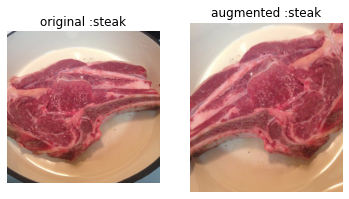

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = 'drive/MyDrive/data-food/10_food_classes_all_data/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

img = mpimg.imread(random_image_path)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f'original :{target_class}')
plt.axis('off')

aug_img = data_augmentation(tf.expand_dims(img, axis=0),training=True ) # to (1,h,w,c) 
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(aug_img)/255.) # to (h,w,c)
plt.title(f'augmented :{target_class}')
plt.axis('off');

### Model Checkpoint Callback 

> We make sure to pass `training=False` when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

> It is used to define how many batches of samples to use in one epoch. It is used to declaring one epoch finished and starting the next epoch.

In [12]:
checkpoint_path = 'drive/MyDrive/data-food/model_checkpoint/checkpoint.ckpt'
ModelCheckPoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,
                                                     save_the_best_only=False)

In [72]:
#Building a model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # actually top is output
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # give model after augmented and don't train it
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool2D')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])
hist_2 = model_2.fit(train_data, epochs=3, 
                     steps_per_epoch= int(len(train_data) * .1), 
                     validation_data = test_data,
                     validation_steps = int(len(test_data) * .1),
                     callbacks=[ModelCheckPoint])

Epoch 1/3
23/23 [==============================] - 73s 3s/step - loss: 2.0091 - accuracy: 0.3288 - val_loss: 1.4975 - val_accuracy: 0.6295
Epoch 2/3
23/23 [==============================] - 60s 3s/step - loss: 1.4752 - accuracy: 0.5870 - val_loss: 1.0789 - val_accuracy: 0.7321
Epoch 3/3
23/23 [==============================] - 64s 3s/step - loss: 1.1414 - accuracy: 0.6997 - val_loss: 0.8443 - val_accuracy: 0.8080


In [14]:
model_2.evaluate(test_data)

79/79 [==============================] - 109s 1s/step - loss: 0.8727 - accuracy: 0.7844


[0.8727359175682068, 0.7843999862670898]

load checkpoint weights

In [15]:
model_1.load_weights(checkpoint_path)
model_1.evaluate(test_data)

79/79 [==============================] - 109s 1s/step - loss: 0.8727 - accuracy: 0.7844


[0.872735857963562, 0.7843999862670898]

### Fine Tuning and continue train on model_2

In [74]:
base_model.trainable = True 
# freeze all layers expecpt for the top 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# recompile (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [75]:
print(len(model_2.trainable_variables))

12


In [77]:
hist_2_finetune =  model_2.fit(train_data.repeat(), #if batch run out will repeat at start
                              epochs=7,
                              steps_per_epoch= int(len(train_data)*.4),
                              validation_data=test_data.repeat(),
                              initial_epoch=hist_2.epoch[-1], # start from previous last epoch
                              validation_steps=int(0.1 * len(test_data)))

Epoch 3/7
94/94 [==============================] - 225s 2s/step - loss: 0.8019 - accuracy: 0.7497 - val_loss: 0.5406 - val_accuracy: 0.8080
Epoch 4/7
94/94 [==============================] - 181s 2s/step - loss: 0.7627 - accuracy: 0.7517 - val_loss: 0.5310 - val_accuracy: 0.8125
Epoch 5/7
94/94 [==============================] - 178s 2s/step - loss: 0.6498 - accuracy: 0.7932 - val_loss: 0.4276 - val_accuracy: 0.8438
Epoch 6/7
94/94 [==============================] - 172s 2s/step - loss: 0.5825 - accuracy: 0.8158 - val_loss: 0.3214 - val_accuracy: 0.8973
Epoch 7/7
94/94 [==============================] - 175s 2s/step - loss: 0.6076 - accuracy: 0.8035 - val_loss: 0.3653 - val_accuracy: 0.8750


In [78]:
def compare_history(hist_1,hist_2, initial_epochs=3):
    acc = hist_1.history["accuracy"]
    loss = hist_1.history["loss"]
    val_acc = hist_1.history["val_accuracy"]
    val_loss = hist_1.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + hist_2.history["accuracy"]
    total_loss = loss + hist_2.history["loss"]
    total_val_acc = val_acc + hist_2.history["val_accuracy"]
    total_val_loss = val_loss + hist_2.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

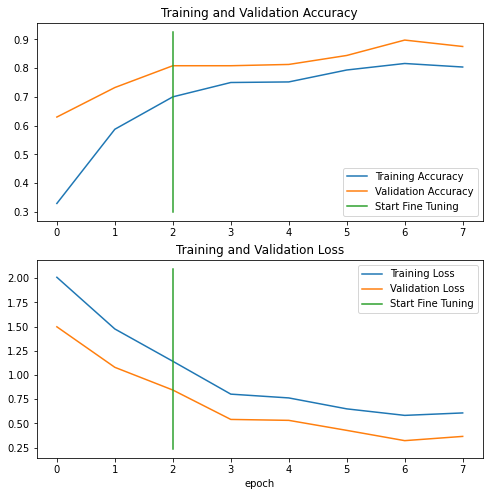

In [79]:
compare_history(hist_2, hist_2_finetune)

In [81]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool2D (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [82]:
model_2.evaluate(test_data)

79/79 [==============================] - 113s 1s/step - loss: 0.4131 - accuracy: 0.8648


[0.41310179233551025, 0.864799976348877]